# Think of the Children
For our analysis of the various neighborhoods of Pittsburgh, we wanted to asses which neighborhood might be most well-suited to raising kids.

In seeking out that end, we looked at three metrics:
* Rate of Childhood Lead exposure
    - This metric is self-explanitory. Lead exposure during childhood is highly correlated with developmental issues, especially related to learning and IQ. A good neighborhood will not run the risk of exposing children to lead through the larger environment.
* Rate of Assault and DUI arrests
    - The amount of assault cases and DUI arrests can heavily influence someone's decision on raising their kid in certain areas. These type of arrests can influence children and how they develop or how safe they are in certain areas.
* Percent of residents enrolled in education
    - lorem ipsum put your explanation of why its important

In [10]:
import pandas as pd
import geopandas as gp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Lead in the Water

For my dataset, I decided to analyze neighborhoods based on likelihood of childhood lead exposure. Obviously, for a neighborhood to be suitable to raise kids, there should be a very low chance of lead exposure (ideally none!).

The WPRDC helpfully has historical data going back to 2015, with a column in their dataset (`percentEBLL15_20`) representing the total positive cases divided by the number of children tested, as a percent. Because the data is representative only of *tested cases* and is **not** therefore necessarily indicative of lead levels across the entire population of a given neighborhood. This, combined with the fact that before 2018 testing was not mandatory for all children, means that the data may be skewed to the high end, as many cases might have been tested only as the result of some concern, rather than for pure peace-of-mind. It is to be noted that wealthier neighborhoods may be more likely to engage in such peace-of-mind testing with generally higher access to medical care, but the Allegheny County Health Department does make child lead testing free.

For our purposes of attemting to compare neighborhoods we will choose to evaluate the neighborhoods on lead exposure only. The same forces will likely be acting upon the city at large, and we can therefore assess that regions of the city with lower incidence of elevated lead levels are generally less likely to expose a child to lead, and certainly if a neighborhood has zero cases of elevated blood lead, they must be doing something right.

In [11]:
nb = gp.read_file("neighborhoods/Neighborhoods_.shp")
ell = pd.read_csv("elevated-blood-lead-levels.csv")
nb.insert(0,"tract",nb['tractce10'].fillna(0).astype("int64", errors='ignore'))
ell.insert(0,"tract",(ell["CensusTract"]-42003000000))
ellnb = nb.merge(ell, how="left", on="tract")

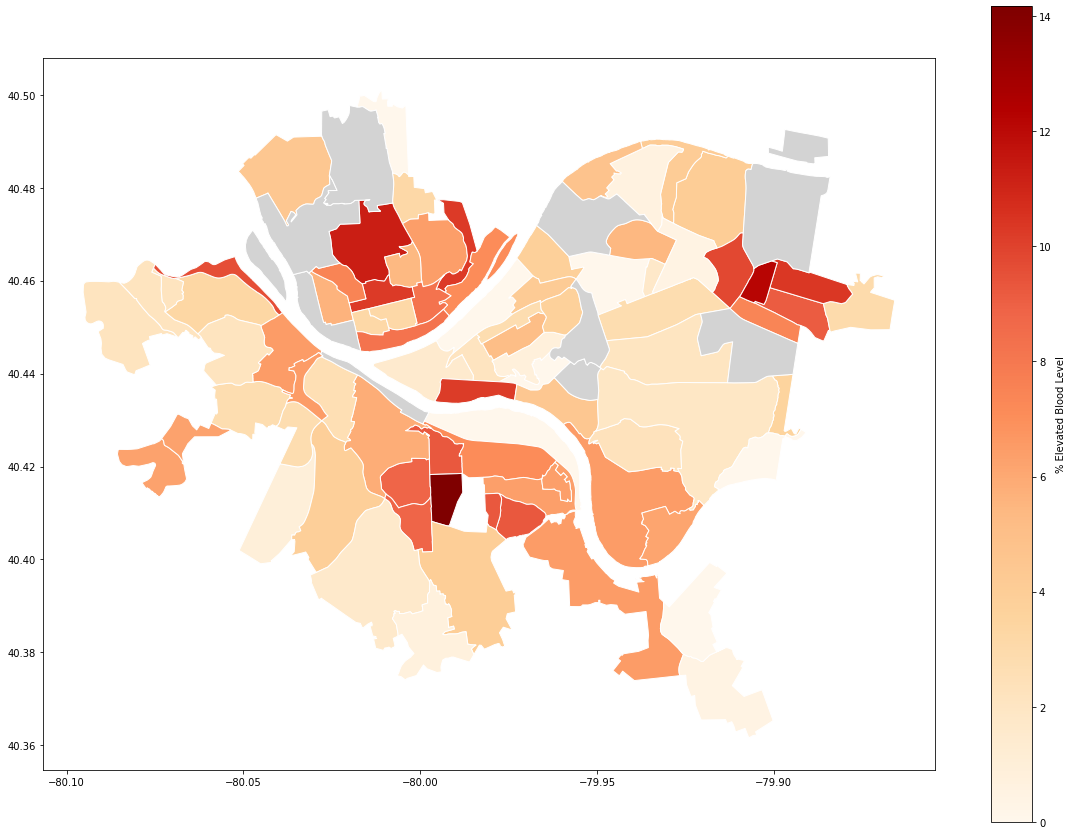

In [12]:
ellnb.plot(column='percentEBLL15_20', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "% Elevated Blood Level"}, # label the legend
               figsize=(20, 15),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

## A Bird's-eye View
On the map we can see that certain clusters develop, and generally that a neighborhood with high incidence of elevated lead levels indicates that the neighboring neighborhoods are also generally higher.

Three such clusters seem to dominate the map, centered on the three neighborhoods with the highest incidence of EBLL: Knoxville, Homewood West, and Perry South.

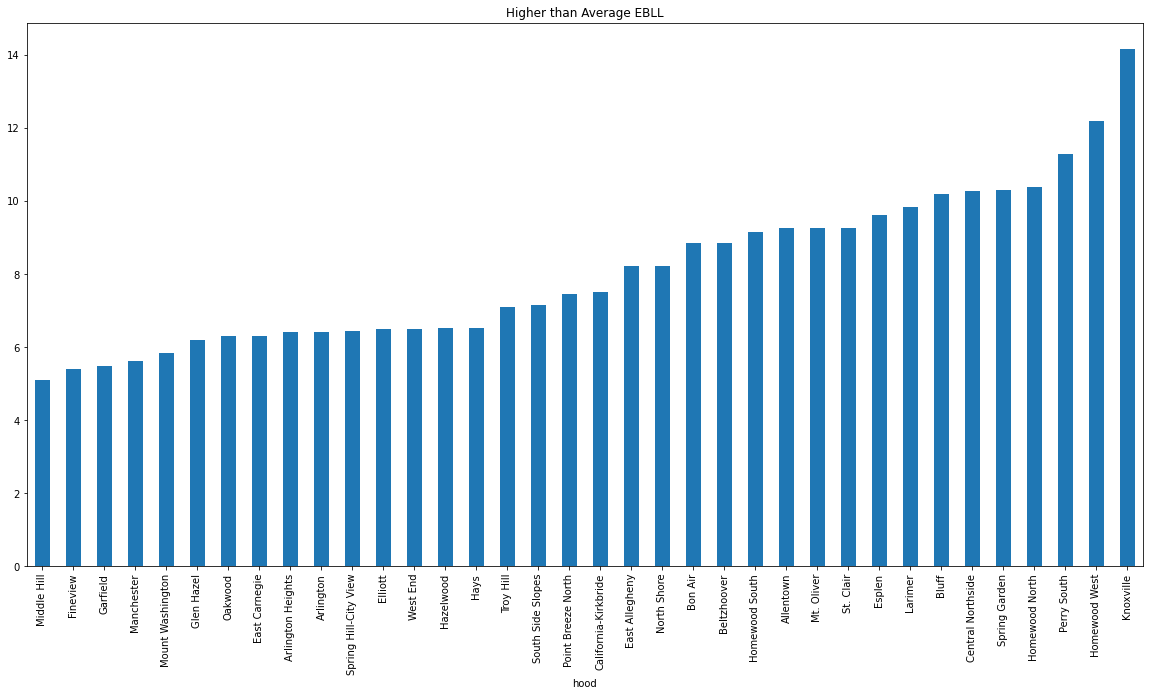

In [13]:
ezview = ellnb[['hood','percentEBLL15_20']].dropna().sort_values('percentEBLL15_20')
mean = ezview['percentEBLL15_20'].mean()
stddev = ezview['percentEBLL15_20'].std()
higher_than_avg = ezview['percentEBLL15_20'] > mean
ezview[higher_than_avg].plot(kind='bar',
                             x='hood',
                             y='percentEBLL15_20',
                             figsize=(20,10),
                             #xlabel='Neighborhood',
                             #ylabel='EBLL rate in tested children',
                             legend=False,
                             title='Higher than Average EBLL')

## 36 Utter Failures
Here we see the list of neighborhoods with higher-than-average rates of exposure. Certainly none of these should be very eligible for best-neighborhood status. I'd be tempted to disqualify any of these neighborhoods from the running for best neighborhood in the city, because as we've said, ideally a neighborhood will be near zero. However, it's possible that a neighborhood can be among the best for our other metrics, while doing poorly in this one.

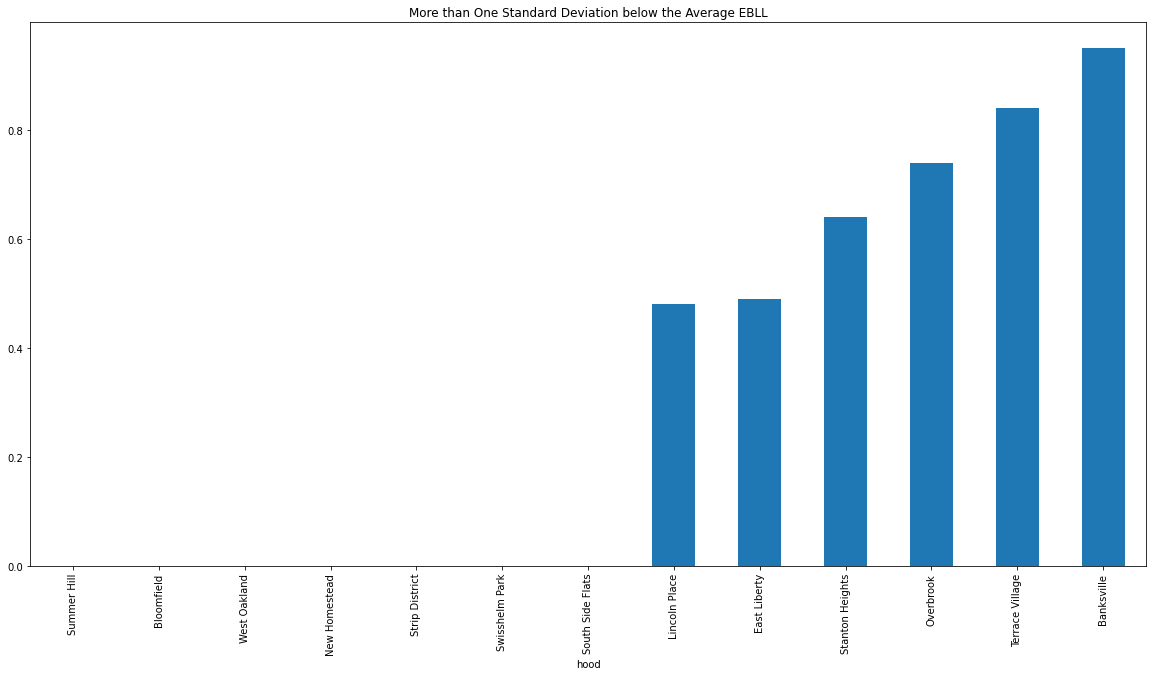

In [14]:
doing_good = ezview['percentEBLL15_20'] < mean - stddev
ezview[doing_good].plot(kind='bar',
                        x='hood',
                        y='percentEBLL15_20',
                        figsize=(20,10),
                        #xlabel='Neighborhood',
                        #ylabel='EBLL rate in tested children',
                        legend=False,
                        title='More than One Standard Deviation below the Average EBLL')

## Paragons
Here we see the 13 neighborhoods who are doing exceptionally well for themselves, with EBLL less than 1.41, 1 standard deviation below the mean. Interestingly, they all fall below 1% incidence.

More than that, there are a full *SEVEN* neighborhoods with zero cases in their tests! Such numbers should be taken with a grain of salt, because as stated the collected statistic is only as a percent of tested children, but zero incidence in a population large enough for the ACHD to publish is something to be celebrated.

It's not spectacularly feasible to choose among seven equally-excellent neighborhoods, instead there's a seven-way tie! Congratulations to Summer Hill, Bloomfield, West Oakland, New Homstead, the Strip District, Swisshelm Park, and the South Side Flats for not exposing their children to lead!

At this point, it may be worthwhile for us to give each neighborhood a score, to help us in our later task of determining the best neighborhood in the city. Because of the scale of our data, subtracting a scaled version of the incidence of EBLL from 100 seems reasonable.

In [15]:
EBLLscored = ezview.copy()
EBLLscored.insert(2,'EBLLscore',100-(EBLLscored['percentEBLL15_20']*10))
EBLLscored = EBLLscored[['hood','EBLLscore']]
EBLLscored.head(10)

,hood,EBLLscore
1,Summer Hill,100.0
24,Bloomfield,100.0
38,West Oakland,100.0
20,New Homestead,100.0
40,Strip District,100.0
54,Swisshelm Park,100.0
61,South Side Flats,100.0
19,Lincoln Place,95.2
35,East Liberty,95.1
51,Stanton Heights,93.6


In [16]:
#Education score
school_data = pd.read_csv('school-enrollment-by-detailed-level-of-school-for-the-population-3-years-and-over.csv')#open the file to read
percent_list = []
neigh_list = []
score_list = []

for index, row in school_data.iterrows():# go through each row 
    percent_list.append(100 * (row[4]/row[2]))     # puts percent into percent list  
    neigh_list.append(row[0])     # put neighborhood in
    
d = {'Neighborhood': neigh_list, 'Education Score of Neighborhood': percent_list}#create new data set with neighborhoods and percentages
percent_list = pd.DataFrame(data=d)# creates a new df so we can get the right scale for the points

for index, row in percent_list.iterrows():# go through each row 
    score_list.append(100 * (row[1]/percent_list["Education Score of Neighborhood"].max()))# append new score scale to score_list 

d = {'Neighborhood': neigh_list, 'Education Score of Neighborhood': score_list}#create new data set with neighborhoods and percentages
eduscored = pd.DataFrame(data=d)

Text(0.5, 0, 'Neighborhoods')

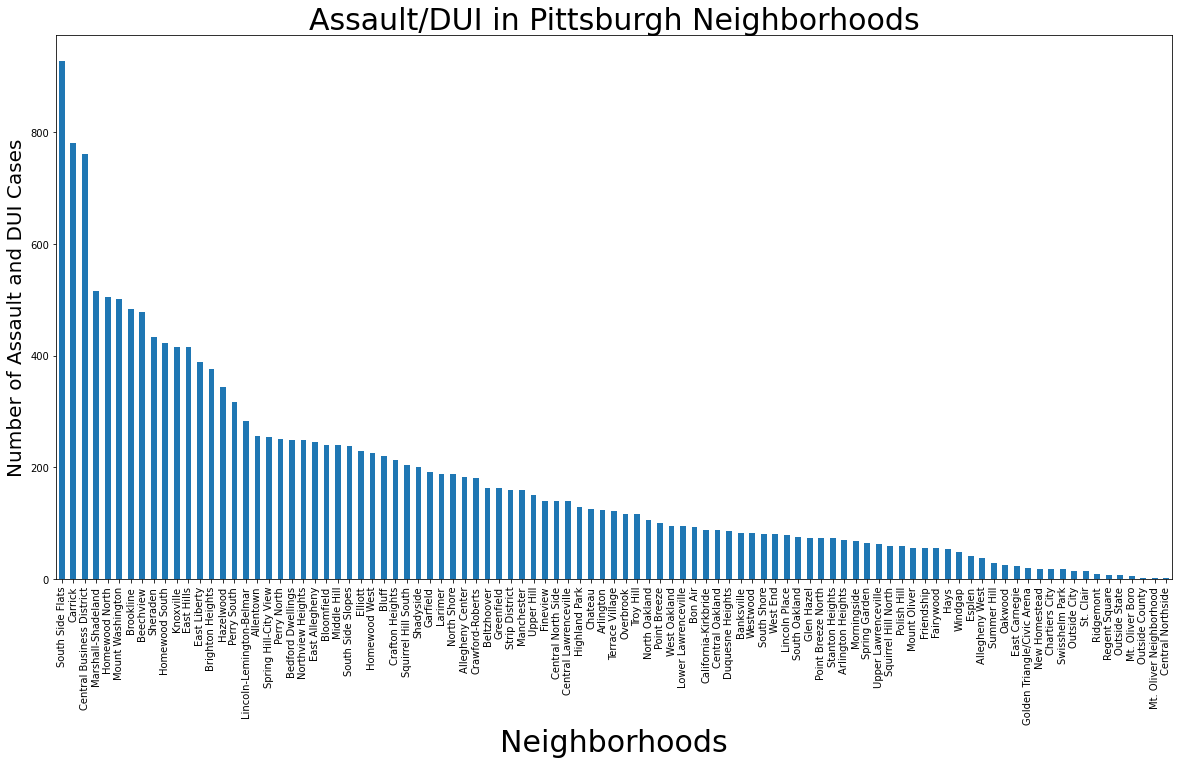

In [17]:
police_arrest = pd.read_csv("police_arrest.csv")
filter1 = police_arrest["OFFENSES"].str.contains("dui", case = False, na = False)
filter2 = police_arrest["OFFENSES"].str.contains("assault", case = False, na = False)
p = police_arrest[filter1 | filter2]
p["INCIDENTNEIGHBORHOOD"].value_counts().plot(kind="bar", figsize = (20,10))
plt.title("Assault/DUI in Pittsburgh Neighborhoods", fontsize = 30)
plt.ylabel('Number of Assault and DUI Cases', fontsize = 20)
plt.xlabel('Neighborhoods', fontsize = 30)

# Graph Analysis 1

<p>I created a two filters and plotted the data. As you can see, the bar graph consists of data that shows the amount of assault cases and DUI's in each neighborhood in the city of Pittsburgh. These two metrics are most essential to determining what neighborhood is the safest plan to reside in. Instead of just analyzing the amount of arrest, we can analyze the amount of DUI's and assault cases to determine which neighborhood is the safest. From the bar graph, we can see that many neighborhoods in Pittsburgh have under 50 assault cases and DUI's since September of 2016, which make then plausible of being relatively safe based on arrest data.</p>

<p>However, the exact number of assault and DUI cases in these neighborhoods can't be analyzed effectively, as we don't take into account the amount of arrest. We must find the percentage of arrests that are assaults and DUI cases to better determine how safe each neighborhood in Pittsburgh actually is.</p>

Text(0.5, 0, 'Neighborhood')

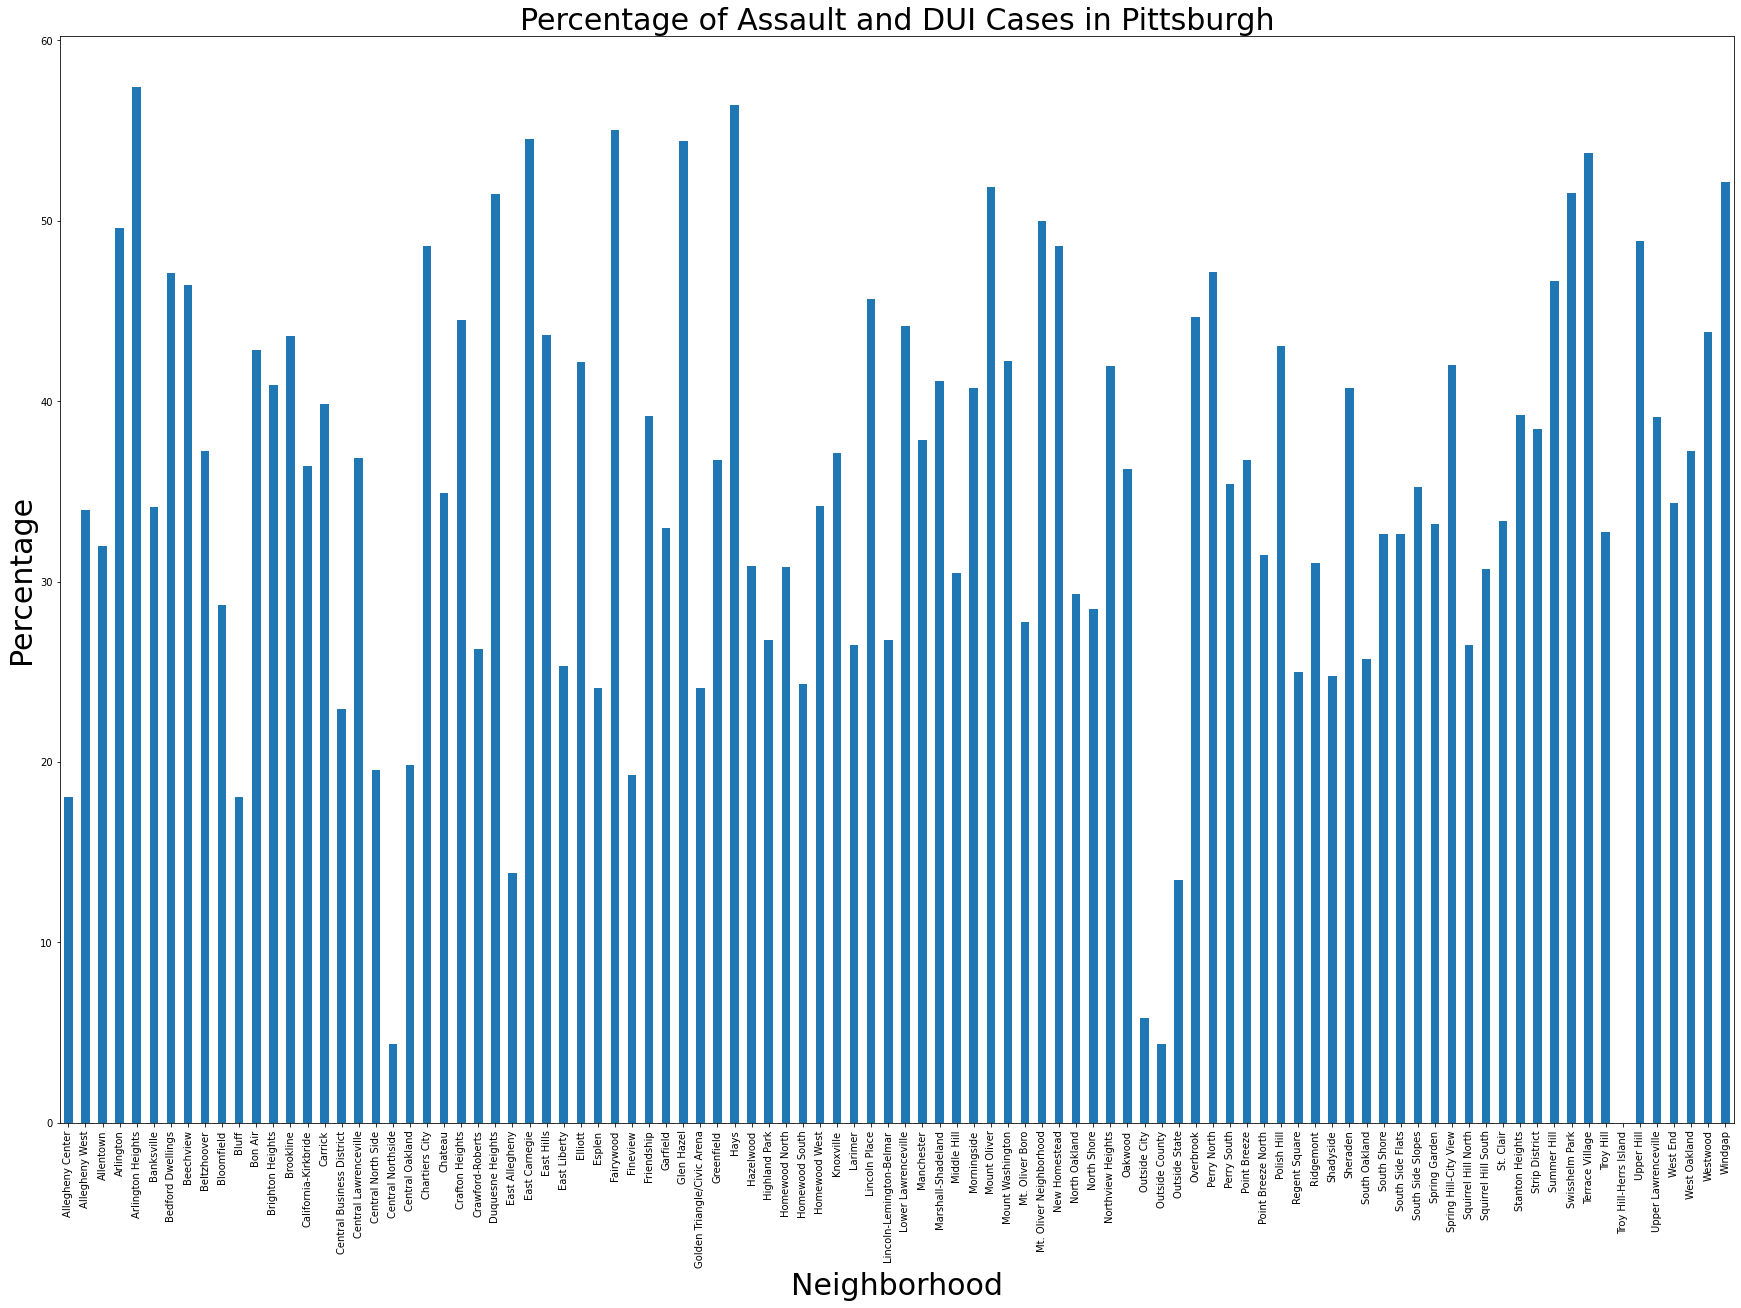

In [18]:
percent = (p["INCIDENTNEIGHBORHOOD"].value_counts()/police_arrest["INCIDENTNEIGHBORHOOD"].value_counts()) * 100
percent.fillna(0, inplace = True)
score = 100 - percent
lawscored = score.sort_values()
ls = lawscored.to_frame().reset_index()
percent.plot(kind = "bar", figsize = (30,20))
plt.title("Percentage of Assault and DUI Cases in Pittsburgh", fontsize = 30)
plt.ylabel("Percentage", fontsize = 30)
plt.xlabel("Neighborhood", fontsize = 30)


# Conclusion

<p>The neighborhoods in Pittsburgh that would be deemed the safest should have a low percentage in DUI and assault cases to the amount of arrest. Anything near 20% would be deemed relatively safe. According to the bar graph, the nieghborhoods with somewhere around 20% assault and DUI cases include Allegheny Center, Bluff, Central Northside, Central Oakland, East Allegheny, Fireview, Outside City, Outside City, and Outside County.</p>

In [19]:
lawscored

Arlington Heights          42.622951
Hays                       43.617021
Fairywood                  45.000000
East Carnegie              45.454545
Glen Hazel                 45.588235
                             ...    
Outside State              86.538462
Outside City               94.208494
Outside County             95.652174
Central Northside          95.652174
Troy Hill-Herrs Island    100.000000
Name: INCIDENTNEIGHBORHOOD, Length: 98, dtype: float64

# One Score to Rule Them All
The time finally comes to assess which neighborhood might be worthy of the title of best! We decided to give each neighborhood a score out of 100 in order to simplify the process.

Each member of the team decided on an equation to give the neighborhoods a score, based on their individual metric.

In [20]:
merged = EBLLscored.merge(eduscored, how='outer', left_on='hood', right_on='Neighborhood')
merged = merged.merge(ls, how='outer', left_on='hood', right_on='index').fillna(0)
merged.insert(0,'finalscore',merged['EBLLscore']*.4+merged['Education Score of Neighborhood']*.2+merged['INCIDENTNEIGHBORHOOD']*.4)
merged.rename(mapper={'Education Score of Neighborhood':'eduscore','INCIDENTNEIGHBORHOOD':'lawscore'},axis=1,inplace=True)
merged[['hood','finalscore','lawscore','EBLLscore','eduscore']].sort_values('finalscore',ascending=False).head(10)

,hood,finalscore,lawscore,EBLLscore,eduscore
2,West Oakland,76.865913,62.745098,100.0,58.839368
6,South Side Flats,75.310536,67.359155,100.0,41.834371
13,Central Business District,75.262341,77.060066,85.0,52.191573
1,Bloomfield,74.946938,71.291866,100.0,32.150960
8,East Liberty,74.626083,74.657087,95.1,33.616243
17,Squirrel Hill North,74.345770,73.542601,79.0,66.643649
11,Terrace Village,69.727802,46.255507,91.6,72.927995
9,Stanton Heights,67.986369,60.752688,93.6,31.226469
25,Shadyside,67.771504,75.246305,72.1,44.164908
16,Squirrel Hill South,67.451310,69.323308,81.0,36.609933


Above are the top 10 safest neighborhoods to raise children based on the metrics all 3 of us used.

We elected to weight the submetrics, giving 40% weight each to our Assault/DUI score and Lead Exposure score, and 20% weight to the educational score representing our view that the reliable physical safety of the child comes marginally before the educational aspirations of their neighbors in representing what neighborhood is best suited to their upbringing.

Congratulations to West Oakland for being the winner of our Best Neighborhood in Pittsburgh award!